In [5]:
import json

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt

In [6]:
curve_fit = np.polyfit(np.log(df["review_count"]), df["fake_rev_index"], 1)
x = np.linspace(0,1811,num=10000)
y = np.exp(curve_fit[1]) * np.exp(curve_fit[0]*x)

plt.scatter(df["review_count"], df["fake_rev_index"], color="red")
plt.plot(x,y,color="green")
plt.title("Fake reviews index x # Reviews")
plt.xlabel("# of Reviews")
plt.ylabel("Fake reviews index")
plt.show()

NameError: name 'df' is not defined

In [7]:
sns.regplot(df["price"], df["fake_rev_index"], fit_reg=True, color="red", line_kws={'color': 'green'}, ci=None)
plt.title("Fake reviews index x Price range")
plt.xlabel("Price")
plt.ylabel("Fake reviews index")
plt.show()

NameError: name 'df' is not defined

In [8]:
plt.hist(df["price"])
plt.show()

NameError: name 'df' is not defined

In [9]:
plt.hist(df["rating"])
plt.show()

NameError: name 'df' is not defined

## Data Visualization

### Filtering Data

Import the dataset

In [11]:
df = pd.read_csv("./../datasets/enh_restaurants/enh_restaurants.csv.zip", index_col = 0)
df.head(1)

,id,alias,name,is_closed,review_count,categories,rating,price,coordinates.latitude,coordinates.longitude,arrondissement,freview_count,freview_pct
0,n7kTFfsmh2P4DJs2oCqGhw,the-wok-store-paris,The Wok Store,False,1,['wok'],3.0,3,48.86924,2.33419,2.0,1.0,0.5


Obtaining the arrondissement for each restaurant

In [59]:
def get_ar(location):
    zipcode_str = eval(location)['zip_code']
    
    if zipcode_str == '':
        return '0'
    
    zipcode_int = int(zipcode_str)

    if zipcode_int > 75000 and zipcode_int <= 75020:
        ar = zipcode_int - 75000
        return str(ar)

# get the arrondissement for each restaurant
arrondissements = pd.DataFrame(df['location'].apply(get_ar))
arrondissements.columns = ['c_ar']

Obtaining the coordinates for each restaurant

In [60]:
# get the latitude and longitude for each restaurant
coords = df['coordinates'].apply(lambda coords: [eval(coords)['latitude'], eval(coords)['longitude']])
coords = coords.apply(pd.Series)
coords.columns = ['lat', 'lon']

Obtaining price ranges for each restaurant

In [95]:
price_ranges = pd.DataFrame(df['price'].dropna().apply(len))
price_ranges.columns = ['price_range']

Inner join of all filtered attributes

In [96]:
original_columns = ['alias', 'name', 'is_closed', 'review_count', 'categories', 'rating', 'fake_review_count']
objects = (df[original_columns], arrondissements, coords, price_ranges)
data = pd.concat(objects, join='inner', axis=1)
data.head()

,alias,name,is_closed,review_count,categories,rating,fake_review_count,c_ar,lat,lon,price_range
0,le-délice-paris-4,Le Délice,False,1,"[{'alias': 'vietnamese', 'title': 'Vietnamese'...",4.0,0.0,3,48.86631,2.363910,2
4,nambodaï-paris-2,Nambodaï,False,15,"[{'alias': 'vietnamese', 'title': 'Vietnamese'...",3.0,2.0,11,48.86428,2.368910,4
5,délice-house-paris-5,Délice House,False,16,"[{'alias': 'vietnamese', 'title': 'Vietnamese'...",3.5,1.0,4,48.85450,2.363310,2
7,health-inside-paris,Health Inside,False,5,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.5,2.0,3,48.86244,2.362130,2
8,le-stand-paris,Le Stand,False,2,"[{'alias': 'vegan', 'title': 'Vegan'}, {'alias...",5.0,1.0,3,48.86284,2.362215,2


### Visualizing data spacially

In this section, we will perform several analyses of the obtained data over Paris' map.

In [13]:
ratings_avg = pd.DataFrame(df.groupby('arrondissement')['rating'].mean())
ratings_avg = ratings_avg.rename_axis('arrondissement').reset_index()
ratings_avg = ratings_avg[ratings_avg['arrondissement'] != '0'].reset_index(drop=True)

In [14]:
from urllib.request import urlopen
import json
with urlopen('https://www.data.gouv.fr/fr/datasets/r/4765fe48-35fd-4536-b029-4727380ce23c') as response:
    arrondissements_map = json.load(response)

In [17]:
import plotly.express as px

fig = px.choropleth_mapbox(ratings_avg, geojson=arrondissements_map, locations='arrondissement', color='rating',
                           color_continuous_scale="Deep", mapbox_style="carto-positron",
                           range_color=(min(ratings_avg['rating']), max(ratings_avg['rating'])),
                           zoom=11, center = {"lat": df.mean()['coordinates.latitude'], "lon": df.mean()['coordinates.longitude']},
                           opacity=0.4, featureidkey = 'properties.arrondissement', labels={'rating':'rating avg'},)

fig.update_layout(
    title={
        'text': 'Yelp\'s Restaurant Rating Averages by Paris Arrondissement',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.update_layout(margin={"r":0,"t":80,"l":0,"b":0})
fig.show()

In [67]:
px.set_mapbox_access_token(open('.mapbox_token').read())

fig = px.scatter_mapbox(data, lat='lat', lon='lon', color='rating', size='review_count',
                        color_continuous_scale='Deep', size_max=20, zoom=11,
                        range_color=(min(data['rating']), max(data['rating'])))

fig.update_layout(
    title={
        'text': 'Yelp\'s Restaurant Ratings in Paris',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.update_layout(margin={"r":0,"t":80,"l":0,"b":0})
fig.show()

### Analysis

We want to see how the percentage of fake reviews compare with the total number of reviews.

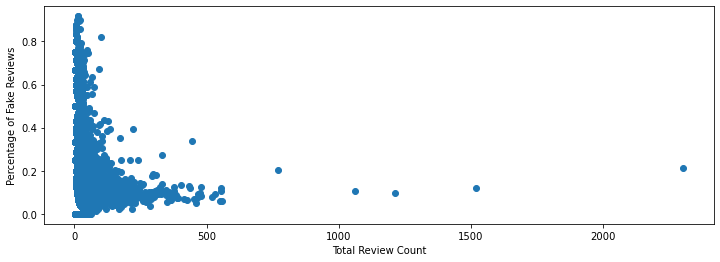

In [89]:
total_review_count = data['fake_review_count'] + data['review_count']
fake_pct = data['fake_review_count']/total_review_count

plt.figure(figsize=(12,4))
plt.scatter(total_review_count, fake_pct)
plt.xlabel('Total Review Count')
plt.ylabel('Percentage of Fake Reviews')
plt.show()

We can see that this curve ressembles a decaying exponential curve. This means that more reviewed restaurants have a smaller percentage of fake reviews. With this data, we can find the probability distribution for percentage of fake reviews given the total number of reviews.

**POSSIBLE**
This tells us that large, well known restaurants are less subject to fake reviews, while smaller restaurants are more likely to have them. This may happen because small business owners may try to write fake reviews for themselves or for competitors in order to obtain competitive advantage.

price_range      1       2      3      4
rating                                  
1.0           18.0    29.0   20.0    NaN
1.5           10.0    26.0   11.0    2.0
2.0           35.0   126.0   37.0    6.0
2.5           49.0   273.0  101.0   19.0
3.0          137.0   720.0  265.0   54.0
3.5          220.0  1315.0  491.0   84.0
4.0          288.0  1559.0  629.0  123.0
4.5          165.0   757.0  313.0   90.0
5.0           94.0   198.0   78.0   26.0
price_range      1       2      3      4
rating                                  
1.5           10.0    26.0   11.0    2.0
2.0           35.0   126.0   37.0    6.0
2.5           49.0   273.0  101.0   19.0
3.0          137.0   720.0  265.0   54.0
3.5          220.0  1315.0  491.0   84.0
4.0          288.0  1559.0  629.0  123.0
4.5          165.0   757.0  313.0   90.0
5.0           94.0   198.0   78.0   26.0


<AxesSubplot:xlabel='price_range', ylabel='rating'>

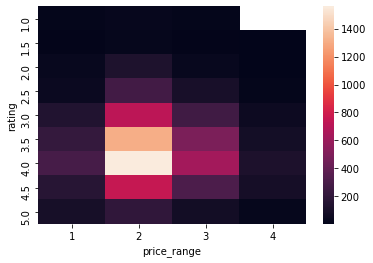

In [161]:
import seaborn as sns


table = data.groupby(['price_range', 'rating']).count()['alias'].reset_index()
pivot = table.pivot_table('alias', 'rating', 'price_range')
print(pivot)
print(pivot)

sns.heatmap(pivot)

In [106]:
data.groupby('rating').mean()

,is_closed,review_count,fake_review_count,lat,lon,price_range
rating,,,,,,
1.0,False,1.716418,1.388060,48.861194,2.343472,2.029851
1.5,False,13.857143,3.591837,48.860634,2.327387,2.102041
2.0,False,10.627451,3.348039,48.861851,2.337885,2.068627
2.5,False,14.504525,3.714932,48.861195,2.332115,2.203620
3.0,False,20.472789,4.426020,48.861673,2.332615,2.200680
3.5,False,29.333649,5.115695,48.860689,2.334525,2.208057
4.0,False,30.080416,4.648576,48.861371,2.337570,2.225856
4.5,False,30.915472,4.856604,48.861632,2.335982,2.247547
5.0,False,5.707071,1.865823,48.863538,2.333084,2.090909
